In [1]:
pip install pykrx

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 23.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.2/52.2 kB 5.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 247.1/247.1 kB 24.0 MB/s eta 0:00:00


In [2]:
from pykrx import stock

# tickers = stock.get_market_ticker_list(조회일자(YYYYmmdd) [,market=조회할 시장(KOSPI, KOSDAQ, ALL])
# name = get_market_ticker_name(심볼 [,market=조회할 시장(KOSPI, KOSDAQ, ALL])
# ohlcv = stock.stock.get_market_ohlcv(조회일자(YYYYmmdd) [,앞에 시작일을 넣었다면 종료일] [,심볼] )

In [3]:
# 예시
tickers = stock.get_market_ticker_list("20230925", market="KOSPI") # 코스피 종목 리스트
name = stock.get_market_ticker_name("005930") # 기업 이름
ohlcv1 = stock.get_market_ohlcv("20230925", market="KOSPI") # 특정일 코스피 종목들의 OHLCV
ohlcv2 = stock.get_market_ohlcv("20230901", "20230925", "005930") # 특정기간 특정 종목의 OHLCV

In [4]:
# 예시출력 1
tickers[:10]

['095570',
 '006840',
 '027410',
 '282330',
 '138930',
 '001460',
 '001465',
 '001040',
 '079160',
 '00104K']

In [6]:
# 예시출력 (기업이름 for 종목번호(심볼) 005930)
name

'삼성전자'

In [7]:
# 예시출력 3 (여러 종목에 대해)
ohlcv1[:10]

,시가,고가,저가,종가,거래량,거래대금,등락률
티커,,,,,,,
095570,4215,4300,4145,4155,141533,593860440,-1.420000
006840,18490,18490,18140,18490,3511,63911920,0.870000
027410,3555,3575,3505,3520,65612,232288350,-1.540000
282330,143900,145500,142400,144200,53239,7655457900,0.840000
138930,7080,7080,6960,7020,603854,4242108340,-0.280000
001460,400000,403500,396000,400000,29,11614000,0.000000
001465,140100,140100,140000,140000,8,1120100,-0.070000
001040,88500,93000,88500,91100,205209,18767536900,2.360000
079160,5750,5910,5660,5680,7863752,45415610100,-25.459999


In [9]:
# 예시출력 4 (한 종목에 대해 날짜별 - 삼성전자)
ohlcv2[:10]

,시가,고가,저가,종가,거래량,등락률
날짜,,,,,,
2023-09-01,66800,71000,66700,71000,29738235,6.128550
2023-09-04,72900,72900,70700,71200,26286495,0.281690
2023-09-05,70900,71500,70200,70700,12330239,-0.702247
2023-09-06,70700,70800,69700,70000,11414620,-0.990099
2023-09-07,70000,70600,69600,70400,13741241,0.571429
2023-09-08,70200,70300,69600,70300,10688118,-0.142045
2023-09-11,70400,70800,70000,70800,11785462,0.711238
2023-09-12,70800,71000,70400,70500,11688599,-0.423729
2023-09-13,71100,71600,70300,70900,15955797,0.567376


# Price Prediction (Project Start)
Reference: https://www.kaggle.com/code/raoulma/ny-stock-price-prediction-rnn-lstm-gru

1. Setting

In [10]:
import numpy as np
import pandas as pd
import math
import sklearn
import sklearn.preprocessing
import datetime
import os
import matplotlib.pyplot as plt
# import tensorflow as tf

In [11]:
# split data in 80%/10%/10% (train/validation/test)
valid_set_size_percentage = 10
test_set_size_percentage = 10

2. Analyze Data

In [63]:
# 주가 데이터 샘플

df  = stock.get_market_ohlcv("20230101", "20230925", "005930")
# df = stock.get_market_ohlcv("20230925", market="KOSPI")
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 183 entries, 2023-01-02 to 2023-09-25
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   시가      183 non-null    int32  
 1   고가      183 non-null    int32  
 2   저가      183 non-null    int32  
 3   종가      183 non-null    int32  
 4   거래량     183 non-null    int32  
 5   등락률     183 non-null    float64
dtypes: float64(1), int32(5)
memory usage: 6.4 KB


,시가,고가,저가,종가,거래량,등락률
날짜,,,,,,
2023-01-02,55500,56100,55200,55500,10031448,0.361664
2023-01-03,55400,56000,54500,55400,13547030,-0.180180
2023-01-04,55700,58000,55600,57800,20188071,4.332130
2023-01-05,58200,58800,57600,58200,15682826,0.692042
2023-01-06,58300,59400,57900,59000,17334989,1.374570


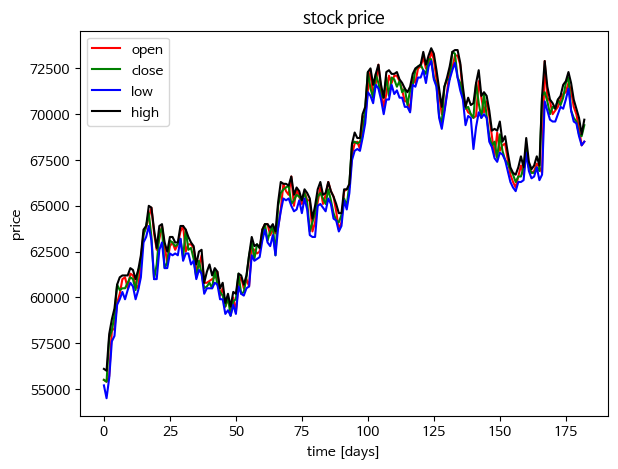

In [64]:
# Draw Figure

plt.figure(figsize=(15, 5));
plt.subplot(1,2,1);
plt.plot(df.시가.values, color='red', label='open')
plt.plot(df.종가.values, color='green', label='close')
plt.plot(df.저가.values, color='blue', label='low')
plt.plot(df.고가.values, color='black', label='high')
plt.title('stock price')
plt.xlabel('time [days]')
plt.ylabel('price')
plt.legend(loc='best')
plt.show()

In [68]:
# column 명 변경
df.columns = ['open', 'high', 'low', 'close', 'volume', 'RoC']

In [69]:
df.head()

,open,high,low,close,volume,RoC
날짜,,,,,,
2023-01-02,55500,56100,55200,55500,10031448,0.361664
2023-01-03,55400,56000,54500,55400,13547030,-0.180180
2023-01-04,55700,58000,55600,57800,20188071,4.332130
2023-01-05,58200,58800,57600,58200,15682826,0.692042
2023-01-06,58300,59400,57900,59000,17334989,1.374570


# 3. Manipulate Data


*  choose a specific stock
*  drop feature: volume
*  normalize stock data
*  create train, validation and test data sets









In [70]:
# function for min-max normalization of stock

def normalize_data(df):
    min_max_scaler = sklearn.preprocessing.MinMaxScaler()
    df['open'] = min_max_scaler.fit_transform(df.open.values.reshape(-1,1))
    df['high'] = min_max_scaler.fit_transform(df.high.values.reshape(-1,1))
    df['low'] = min_max_scaler.fit_transform(df.low.values.reshape(-1,1))
    df['close'] = min_max_scaler.fit_transform(df['close'].values.reshape(-1,1))
    return df

In [71]:
# function for crate train/val/test data given stock data and sequence length

def load_data(stock, seq_len):
    data_raw = stock.values # stock.as_matrix() # convert to numpy array
    data = []

    # create all possible sequences of length seq_len
    for index in range(len(data_raw) - seq_len):
        data.append(data_raw[index: index + seq_len])

    data = np.array(data);
    valid_set_size = int(np.round(valid_set_size_percentage/100*data.shape[0]));
    test_set_size = int(np.round(test_set_size_percentage/100*data.shape[0]));
    train_set_size = data.shape[0] - (valid_set_size + test_set_size);

    print(data)
    x_train = data[:train_set_size,:-1,:]
    y_train = data[:train_set_size,-1,:]

    x_valid = data[train_set_size:train_set_size+valid_set_size,:-1,:]
    y_valid = data[train_set_size:train_set_size+valid_set_size,-1,:]

    x_test = data[train_set_size+valid_set_size:,:-1,:]
    y_test = data[train_set_size+valid_set_size:,-1,:]

    return [x_train, y_train, x_valid, y_valid, x_test, y_test]


In [72]:
# choose one stock
df_stock = df.copy()
df_stock.drop(['RoC'],1,inplace=True)
df_stock.drop(['volume'],1,inplace=True)

cols = list(df_stock.columns.values)
print('df_stock.columns.values = ', cols)


df_stock.columns.values =  ['open', 'high', 'low', 'close']


<ipython-input-72-3d214e43ea25>:3: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  df_stock.drop(['RoC'],1,inplace=True)
<ipython-input-72-3d214e43ea25>:4: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  df_stock.drop(['volume'],1,inplace=True)


In [73]:
# normalize stock
df_stock_norm = df_stock.copy()
df_stock_norm = normalize_data(df_stock_norm)


In [74]:
df_stock_norm # for debugging

,open,high,low,close
날짜,,,,
2023-01-02,0.005556,0.005682,0.038043,0.005556
2023-01-03,0.000000,0.000000,0.000000,0.000000
2023-01-04,0.016667,0.113636,0.059783,0.133333
2023-01-05,0.155556,0.159091,0.168478,0.155556
2023-01-06,0.161111,0.193182,0.184783,0.200000
...,...,...,...,...
2023-09-19,0.833333,0.840909,0.820652,0.800000
2023-09-20,0.811111,0.812500,0.815217,0.788889
2023-09-21,0.766667,0.784091,0.777174,0.750000


In [60]:
temp = df_stock_norm.values
print(temp) # for debugging

[[0.         0.525      0.         0.6875    ]
 [1.         1.         0.85106383 0.75      ]
 [0.67213115 0.65       0.74468085 0.59375   ]
 [0.63934426 0.475      0.63829787 0.375     ]
 [0.52459016 0.425      0.61702128 0.5       ]
 [0.55737705 0.35       0.61702128 0.46875   ]
 [0.59016393 0.475      0.70212766 0.625     ]
 [0.6557377  0.525      0.78723404 0.53125   ]
 [0.70491803 0.675      0.76595745 0.65625   ]
 [0.72131148 0.725      0.87234043 0.90625   ]
 [0.80327869 0.85       1.         1.        ]
 [0.73770492 0.7        0.74468085 0.4375    ]
 [0.59016393 0.475      0.61702128 0.3125    ]
 [0.52459016 0.35       0.59574468 0.25      ]
 [0.39344262 0.225      0.44680851 0.03125   ]
 [0.24590164 0.         0.34042553 0.        ]
 [0.27868852 0.2        0.38297872 0.1875    ]]


In [61]:
len(temp) # for debugging

17

In [75]:
# create train, test data
seq_len = 20 # choose sequence length
x_train, y_train, x_valid, y_valid, x_test, y_test = load_data(df_stock_norm, seq_len)
print('x_train.shape = ',x_train.shape)
print('y_train.shape = ', y_train.shape)
print('x_valid.shape = ',x_valid.shape)
print('y_valid.shape = ', y_valid.shape)
print('x_test.shape = ', x_test.shape)
print('y_test.shape = ',y_test.shape)

[[[0.00555556 0.00568182 0.03804348 0.00555556]
  [0.         0.         0.         0.        ]
  [0.01666667 0.11363636 0.05978261 0.13333333]
  ...
  [0.5        0.51136364 0.51086957 0.51111111]
  [0.52777778 0.50568182 0.4673913  0.43888889]
  [0.45       0.4375     0.35326087 0.31111111]]

 [[0.         0.         0.         0.        ]
  [0.01666667 0.11363636 0.05978261 0.13333333]
  [0.15555556 0.15909091 0.16847826 0.15555556]
  ...
  [0.52777778 0.50568182 0.4673913  0.43888889]
  [0.45       0.4375     0.35326087 0.31111111]
  [0.4        0.38068182 0.35326087 0.35555556]]

 [[0.01666667 0.11363636 0.05978261 0.13333333]
  [0.15555556 0.15909091 0.16847826 0.15555556]
  [0.16111111 0.19318182 0.18478261 0.2       ]
  ...
  [0.45       0.4375     0.35326087 0.31111111]
  [0.4        0.38068182 0.35326087 0.35555556]
  [0.43333333 0.44886364 0.44021739 0.45      ]]

 ...

 [[0.71666667 0.72159091 0.72826087 0.71111111]
  [0.65       0.64772727 0.67391304 0.65      ]
  [0.63333

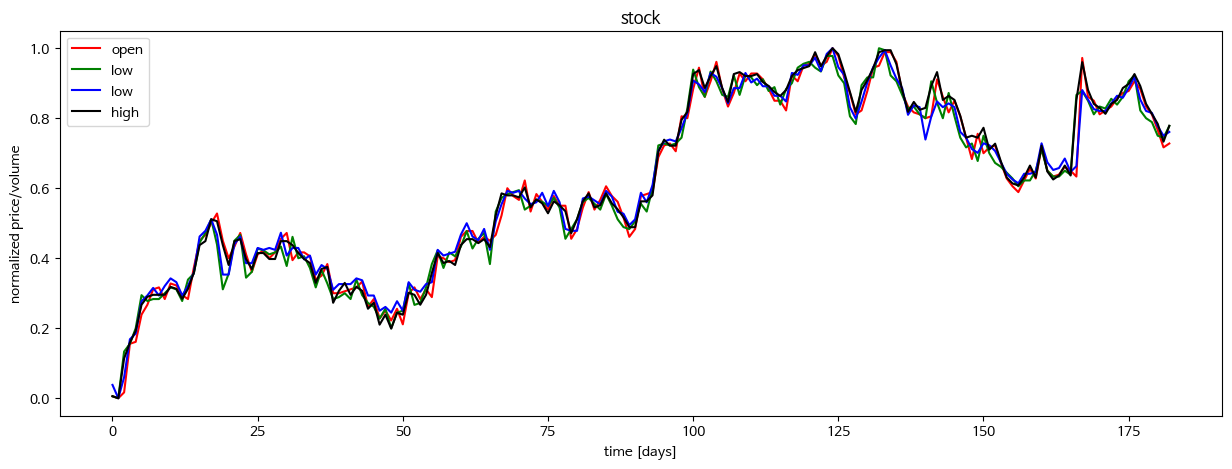

In [76]:
# plot fig

plt.figure(figsize=(15, 5));
plt.plot(df_stock_norm.open.values, color='red', label='open')
plt.plot(df_stock_norm.close.values, color='green', label='low')
plt.plot(df_stock_norm.low.values, color='blue', label='low')
plt.plot(df_stock_norm.high.values, color='black', label='high')
#plt.plot(df_stock_norm.volume.values, color='gray', label='volume')
plt.title('stock')
plt.xlabel('time [days]')
plt.ylabel('normalized price/volume')
plt.legend(loc='best')
plt.show()

## Model and Validate Data

RNNs with basic, LSTM, GRU

In [77]:
# 삭제 예정
index_in_epoch = 0;
perm_array  = np.arange(x_train.shape[0]) # Numpy Array 화
perm_array

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
        91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
       104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
       117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
       130])

In [80]:
## Basic Cell RNN in tensorflow (Pytorch 로 대체 필요)

index_in_epoch = 0;
perm_array  = np.arange(x_train.shape[0]) # Numpy Array 화
np.random.shuffle(perm_array)

# function to get the next batch
def get_next_batch(batch_size):
    global index_in_epoch, x_train, perm_array
    start = index_in_epoch
    index_in_epoch += batch_size

    if index_in_epoch > x_train.shape[0]:
        np.random.shuffle(perm_array) # shuffle permutation array
        start = 0 # start next epoch
        index_in_epoch = batch_size

    end = index_in_epoch
    return x_train[perm_array[start:end]], y_train[perm_array[start:end]]

# parameters
n_steps = seq_len-1
n_inputs = 4
n_neurons = 200
n_outputs = 4
n_layers = 2
learning_rate = 0.001
batch_size = 50
n_epochs = 100
train_set_size = x_train.shape[0]
test_set_size = x_test.shape[0]


In [84]:
# tensorflow 대체 목적

import torch
import torch.nn as nn
import torch.optim as optim

이하는, 레퍼런스의 텐서플로우 코드를 파이토치 코드를 변환한 것이다.

In [86]:
# Define the RNN model
class RNNModel(nn.Module):
    def __init__(self, n_inputs, n_neurons, n_layers, n_outputs):
        super(RNNModel, self).__init__()
        self.rnn = nn.RNN(input_size=n_inputs, hidden_size=n_neurons, num_layers=n_layers, nonlinearity='relu')
        self.fc = nn.Linear(n_neurons, n_outputs)

    def forward(self, x):
        rnn_outputs, _ = self.rnn(x)
        stacked_rnn_outputs = rnn_outputs.view(-1, self.rnn.hidden_size)
        stacked_outputs = self.fc(stacked_rnn_outputs)
        outputs = stacked_outputs.view(-1, n_steps, n_outputs)[:, -1, :]  # Keep only the last output
        return outputs

# Create the RNN model
n_steps = seq_len - 1  # Assuming seq_len is defined
n_inputs = 4
n_neurons = 200
n_outputs = 4
n_layers = 2
learning_rate = 0.001
batch_size = 50
n_epochs = 100
train_set_size = x_train.shape[0]
test_set_size = x_test.shape[0]

model = RNNModel(n_inputs, n_neurons, n_layers, n_outputs)

# Define loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Convert training data to PyTorch tensors
X_train = torch.Tensor(x_train)
y_train = torch.Tensor(y_train)


In [88]:
# Training loop
for epoch in range(n_epochs):
    for iteration in range(0, train_set_size, batch_size):
        x_batch = X_train[iteration:iteration + batch_size]
        y_batch = y_train[iteration:iteration + batch_size]

        optimizer.zero_grad()  # Zero the gradients
        outputs = model(x_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()  # Compute gradients
        optimizer.step()  # Update weights

    # Calculate and print the training and validation loss
    mse_train = criterion(model(X_train), y_train)
    mse_valid = criterion(model(torch.Tensor(x_valid)), torch.Tensor(y_valid))
    print(f"Epoch {epoch + 1}: MSE train/valid = {mse_train.item():.6f}/{mse_valid.item():.6f}")


Epoch 1: MSE train/valid = 0.002765/0.008676
Epoch 2: MSE train/valid = 0.002686/0.008263
Epoch 3: MSE train/valid = 0.002664/0.007702
Epoch 4: MSE train/valid = 0.002579/0.007250
Epoch 5: MSE train/valid = 0.002542/0.006716
Epoch 6: MSE train/valid = 0.002505/0.006195
Epoch 7: MSE train/valid = 0.002463/0.005742
Epoch 8: MSE train/valid = 0.002439/0.005222
Epoch 9: MSE train/valid = 0.002405/0.004775
Epoch 10: MSE train/valid = 0.002370/0.004347
Epoch 11: MSE train/valid = 0.002337/0.003938
Epoch 12: MSE train/valid = 0.002304/0.003548
Epoch 13: MSE train/valid = 0.002274/0.003193
Epoch 14: MSE train/valid = 0.002247/0.002882
Epoch 15: MSE train/valid = 0.002225/0.002582
Epoch 16: MSE train/valid = 0.002205/0.002334
Epoch 17: MSE train/valid = 0.002188/0.002108
Epoch 18: MSE train/valid = 0.002172/0.001927
Epoch 19: MSE train/valid = 0.002159/0.001781
Epoch 20: MSE train/valid = 0.002153/0.001647
Epoch 21: MSE train/valid = 0.002162/0.001487
Epoch 22: MSE train/valid = 0.002139/0.0014

In [89]:
# Perform predictions on the training, validation, and test sets
y_train_pred = model(X_train).detach().numpy()
y_valid_pred = model(torch.Tensor(x_valid)).detach().numpy()
y_test_pred = model(torch.Tensor(x_test)).detach().numpy()


In [92]:
y_train_pred.shape

(131, 4)

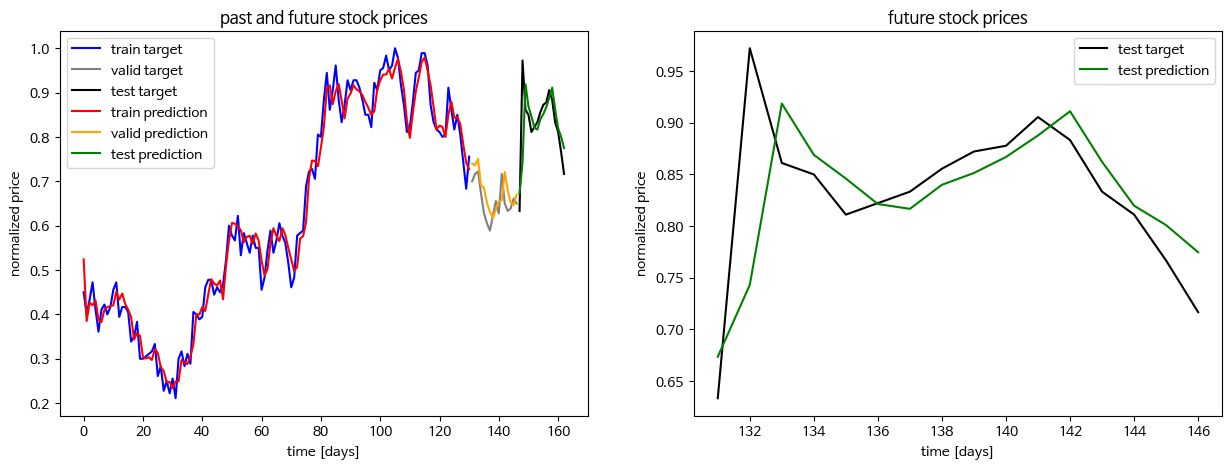

In [98]:
ft = 0 # 0 = open, 1 = high, 2 = low, 3 = close

## show predictions
plt.figure(figsize=(15, 5));
plt.subplot(1,2,1);

plt.plot(np.arange(y_train.shape[0]), y_train[:,ft], color='blue', label='train target')
plt.plot(np.arange(y_train.shape[0], y_train.shape[0]+y_valid.shape[0]), y_valid[:,ft],
         color='gray', label='valid target')
plt.plot(np.arange(y_train.shape[0]+y_valid.shape[0],
                   y_train.shape[0]+y_test.shape[0]+y_test.shape[0]),
         y_test[:,ft], color='black', label='test target')
plt.plot(np.arange(y_train_pred.shape[0]),y_train_pred[:,ft], color='red',
         label='train prediction')
plt.plot(np.arange(y_train_pred.shape[0], y_train_pred.shape[0]+y_valid_pred.shape[0]),
         y_valid_pred[:,ft], color='orange', label='valid prediction')
plt.plot(np.arange(y_train_pred.shape[0]+y_valid_pred.shape[0],
                   y_train_pred.shape[0]+y_valid_pred.shape[0]+y_test_pred.shape[0]),
         y_test_pred[:,ft], color='green', label='test prediction')

plt.title('past and future stock prices')
plt.xlabel('time [days]')
plt.ylabel('normalized price')
plt.legend(loc='best');

plt.subplot(1,2,2);

plt.plot(np.arange(y_train.shape[0], y_train.shape[0]+y_test.shape[0]),
         y_test[:,ft], color='black', label='test target')

plt.plot(np.arange(y_train_pred.shape[0], y_train_pred.shape[0]+y_test_pred.shape[0]),
         y_test_pred[:,ft], color='green', label='test prediction')

plt.title('future stock prices')
plt.xlabel('time [days]')
plt.ylabel('normalized price')
plt.legend(loc='best');

# corr_price_development_train = (torch.sum((torch.sign(y_train[:, 1] - y_train[:, 0]) == torch.sign(y_train_pred[:, 1] - y_train_pred[:, 0])).int()) / y_train.shape[0]).item()
# corr_price_development_valid = (torch.sum((torch.sign(y_valid[:, 1] - y_valid[:, 0]) == torch.sign(y_valid_pred[:, 1] - y_valid_pred[:, 0])).int()) / y_valid.shape[0]).item()
# corr_price_development_test = (torch.sum((torch.sign(y_test[:, 1] - y_test[:, 0]) == torch.sign(y_test_pred[:, 1] - y_test_pred[:, 0])).int()) / y_test.shape[0]).item()

# 이하 오류 코드
# corr_price_development_train = np.sum(np.equal(np.sign(y_train[:,1]-y_train[:,0]),
#             np.sign(y_train_pred[:,1]-y_train_pred[:,0])).astype(int)) / y_train.shape[0]
# corr_price_development_valid = np.sum(np.equal(np.sign(y_valid[:,1]-y_valid[:,0]),
#             np.sign(y_valid_pred[:,1]-y_valid_pred[:,0])).astype(int)) / y_valid.shape[0]
# corr_price_development_test = np.sum(np.equal(np.sign(y_test[:,1]-y_test[:,0]),
#             np.sign(y_test_pred[:,1]-y_test_pred[:,0])).astype(int)) / y_test.shape[0]

# print('correct sign prediction for close - open price for train/valid/test: %.2f/%.2f/%.2f'%(
#     corr_price_development_train, corr_price_development_valid, corr_price_development_test))